In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sympy import symbols, inverse_laplace_transform
from scipy.optimize import minimize

In [2]:
data = loadmat('/content/drive/MyDrive/sinais/assets/GrupoRobo_10.mat')
y = data['z1'][:,0]
u = data['z1'][0,1]
x = np.arange(0, len(y)*0.01, 0.01)

# Plotagem do sinal y(t) medido

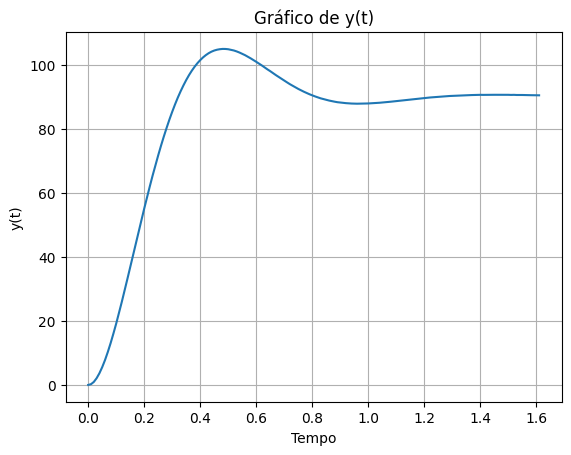

In [3]:
plt.plot(x, y)
plt.ylabel('y(t)')
plt.xlabel('Tempo')
plt.title('Gráfico de y(t)')
plt.grid()
plt.show()

# Resolvendo pelo método 1

## Calculando o valor de pico e sobressinal

In [4]:
max_value = np.max(y)
max_index = np.argmax(y)
diff = y - y[-1]
stateindex = np.where(diff > 0)[0][0]
sobressinal_percentagem = np.abs(y[max_index] - y[stateindex]) / y[stateindex]
sobressinal = -1 * np.log(sobressinal_percentagem) / np.sqrt(np.pi**2 + (np.log(sobressinal_percentagem))**2)

print(f'Sobressinal (zeta): {sobressinal}')

Sobressinal (zeta): 0.5247310879461556


## Calculando a frequência natural e o ganho

In [5]:
# Calculando a frequência natural
tpico = x[max_index]
frequencia_natural = np.pi / (tpico * np.sqrt(1 - sobressinal**2))
print(f'Frequência Natural (wn): {frequencia_natural}')

# Encontrando o ganho K
ganho = y[-1] / u
print(f'Ganho K: {ganho}')

Frequência Natural (wn): 7.688512131209022
Ganho K: 1.0046607842019946


## Calculando a transformada inversa

In [6]:
s, t = symbols('s t')

G = (ganho*frequencia_natural**2) / (s**2 + 2*frequencia_natural*sobressinal*s + frequencia_natural**2)
X = u/s
Y = G*X
f = inverse_laplace_transform(Y, s, t)

f_aprox = np.array([f.subs(t, x_val) for x_val in x])

## Plotagem comparando a aproximação e o real

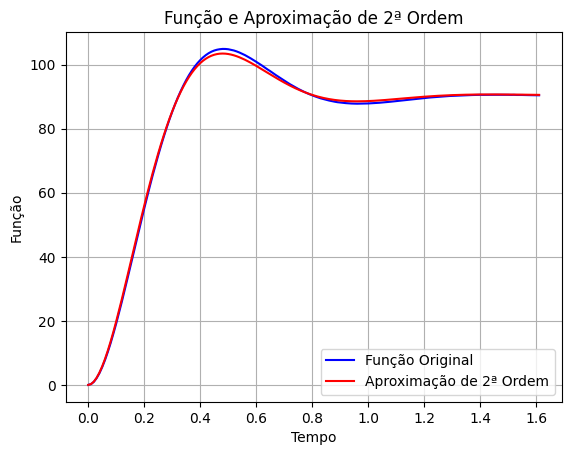

In [7]:
plt.plot(x, y, 'b', label='Função Original')
plt.plot(x, f_aprox, 'r', label='Aproximação de 2ª Ordem')
plt.title('Função e Aproximação de 2ª Ordem')
plt.xlabel('Tempo')
plt.ylabel('Função')
plt.legend(loc=4)
plt.grid()
plt.show()

## Cálculo do erro

In [8]:
mse = float(np.mean((f_aprox - y)**2))
rmse = np.sqrt(mse)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')

MSE: 0.4891
RMSE: 0.6994


# Resolvendo pelo método 2

## Funções para minimizar

In [9]:
def subamortecido(tempo, u, K, zeta, wn):
  wd = wn * np.sqrt(1 - zeta**2)  # Frequência Natural Amortecida
  phi = np.arctan(np.sqrt(1 - zeta**2) / zeta)  # Fase
  N = len(tempo)

  y = np.zeros(N)

  for k in range(N):
    t = tempo[k]
    if t > 0:
      y[k] = u*(K - K/np.sqrt(1-zeta**2) * np.exp(-zeta*wn*t)*np.sin(wd*t+phi))
    else:
      y[k] = 0

  return y

In [10]:
def MSE(p):
  K, zeta, wn = p
  tempo = np.arange(0, len(y)*0.01, 0.01)
  y_esp = subamortecido(tempo, u, K, zeta, wn)

  mse = np.mean((y-y_esp)**2)

  return mse

## Minimizando o erro

In [11]:
params = [ganho, sobressinal, frequencia_natural]
result = minimize(MSE, params, method='Nelder-Mead')

p = result.x
K, zeta, wn = p

print("Optimized parameters (K, sobressinal, frequencia_natural):", p)

Optimized parameters (K, sobressinal, frequencia_natural): [1.00223203 0.50004568 7.50025025]


## Plotagem comparando a aproximação e o real

MSE: 0.0001
RMSE: 0.0091


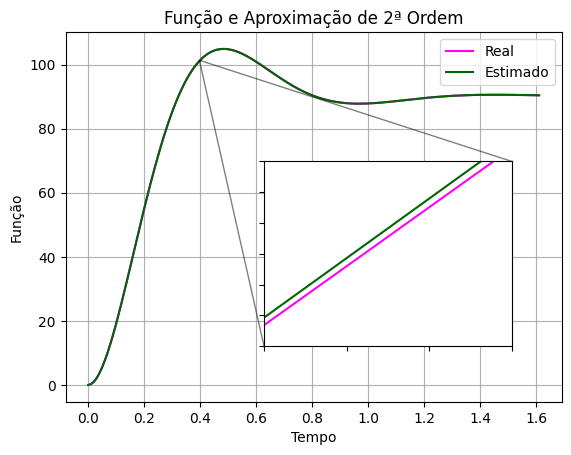

In [12]:
tempo=np.arange(0, len(y)*0.01, 0.01)
y_esp = subamortecido(tempo,u,K,zeta,wn)

mse = np.mean((y - y_esp)**2)
rmse = np.sqrt(mse)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')

fig, ax = plt.subplots()
ax.plot(tempo,y, c='magenta', label='Real')
ax.plot(tempo,y_esp, c='darkgreen', label='Estimado')
ax.set_title('Função e Aproximação de 2ª Ordem')
ax.set_xlabel('Tempo')
ax.set_ylabel('Função')

# inset axe
x1, x2, y1, y2 = 0.3975, 0.399, 101.15, 101.3
axin = ax.inset_axes(
    [0.4, 0.15, 0.5, 0.5],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axin.plot(tempo,y, c='magenta')
axin.plot(tempo,y_esp, c='darkgreen')

ax.indicate_inset_zoom(axin, edgecolor="black")

plt.legend()
plt.grid()
plt.show()